# Import Core Libraries

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
import pickle

from os import listdir, walk
from os.path import isfile, join

In [8]:
from detect_peaks import detect_peaks
import ruptures as rpt

# Load Dataset

In [9]:
%run load_dataset.ipynb

In [10]:
subj_range = np.hstack((np.arange(1001,1013),np.arange(2002,2003)))

all_subjects = [str(i) for i in subj_range]

In [11]:
subj_range = np.hstack((np.arange(2001,2002),np.arange(3001,3006)))

all_patients = [str(i) for i in subj_range]

In [12]:
print(all_subjects)
print(all_patients)

['1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '2002']
['2001', '3001', '3002', '3003', '3004', '3005']


In [15]:
X_all_p, y_all_p, subj_all_p, ts_all_p, hr_all_p = load_all_data(all_patients)

Loading 2001's data
Loading 3001's data
Loading 3002's data
Loading 3003's data
Loading 3004's data
Loading 3005's data
Finished loading


In [16]:
X_all_p.shape

(10998, 3)

# Data Preprocessing

In [17]:
%run preprocessing.ipynb

# Group Data by Label and Normalize Data

In [18]:
print(label_list)
print(label_dict)

['sit', 'sleep', 'stand', 'walk']
{'sit': 0, 'sleep': 1, 'stand': 2, 'walk': 3}


In [19]:
new_label_list = [0,1,2,3]
new_label_dict = {
    0: 'sit',
    1: 'sleep',
    2: 'stand',
    3: 'walk'
}

colors = ['r','g','b','navy','turquoise','darkorange']

In [20]:
# group X_all and y_all from load_dataset.ipynb by labels
X_label, y_label = label_grouping(X_all_p, y_all_p, subj_all_p, all_patients, new_label_list)

# normalize X_label
X_norm = normalize_data(X_label)

## Show Plot for each Activity and Subject

In [21]:
# plot_all_label(X_label, y_all, new_label_list, new_label_dict)

# Calculate Roll, Pitch, Yaw

In [22]:
roll, pitch, yaw = calc_rpy(X_all_p, colors)
rpy_p = np.array([roll, pitch, yaw]).transpose()

print(rpy_p.shape, y_all_p.shape)

(10998, 3) (10998,)


# Apply PCA

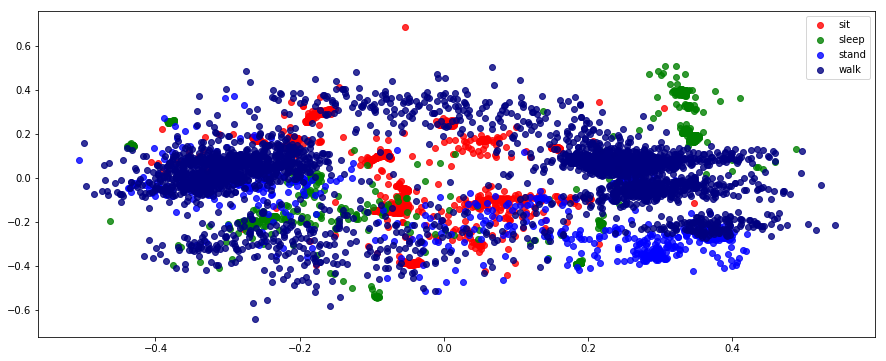

In [23]:
# apply PCA and LDA to X_all and rpy
X_pca_p, pca_p = apply_pca(X_all_p, y_all_p, label_list)
# rpy_pca_p, pca_p = apply_pca(rpy_p, y_all_p, label_list)

# Reshape Data (Pure Label)

In [24]:
# print(rpy_pca_p.shape, y_all_p.shape, subj_all_p.shape)

In [25]:
# get label-separated X and y
X_pure, y_pure = prepare_pure_label(X_pca_p, y_all_p, subj_all_p, all_patients, new_label_list)
y_pure = y_pure.reshape((y_pure.shape[0],))

In [26]:
print(X_pure.shape, y_pure.shape)

(9582, 180) (9582,)


# Reshape Data (Impure Label)

In [27]:
X_impure, y_impure = prepare_impure_label(X_pca_p, y_all_p)

In [28]:
print(X_impure.shape, y_impure.shape)

(10939, 180) (10939,)


# Split Train and Test Set

In [20]:
# Split training data and testing data
X_train, X_test, y_train, y_test = train_test_split(X_pure, y_pure, test_size=0.2, random_state=42)

X_tr, X_te, y_tr, y_te = train_test_split(X_impure, y_impure, test_size=0.2, random_state=42)

print(X_tr.shape)
print(X_te.shape)

(8751, 180)
(2188, 180)


In [21]:
print(X_train.shape)
print(X_test.shape)

(7665, 180)
(1917, 180)


# K-Nearest Neighbors

In [22]:
nn_model = nn_classifier(X_train, y_train)
print("Finished training")

Finished training


In [23]:
filename = basepath + 'model/knn_model_patients.pkl'
pickle.dump(nn_model, open(filename, 'wb'))

In [24]:
y_pred = nn_model.predict(X_test)

In [25]:
nn_model_2 = nn_classifier(X_tr, y_tr)
print("Finished training")

Finished training


In [26]:
y_pred_2 = nn_model_2.predict(X_te)

## Evaluation

In [27]:
%run eval_score.ipynb

In [28]:
LABELS = ['sit','sleep','stand','walk']

0.865414710485133


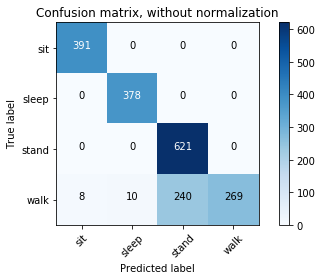

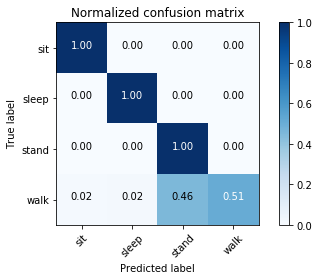

              precision    recall  f1-score   support

         sit       0.98      1.00      0.99       391
       sleep       0.97      1.00      0.99       378
       stand       0.72      1.00      0.84       621
        walk       1.00      0.51      0.68       527

   micro avg       0.87      0.87      0.87      1917
   macro avg       0.92      0.88      0.87      1917
weighted avg       0.90      0.87      0.85      1917



In [29]:
acc = accuracy_score(y_test, y_pred)
print(acc)

show_conf_matrix(y_test, y_pred, LABELS)
show_clf_report(y_test, y_pred, LABELS)

0.8628884826325411


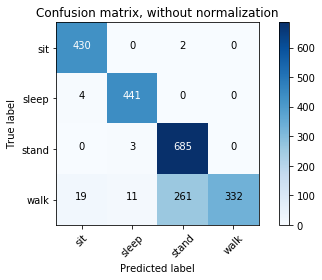

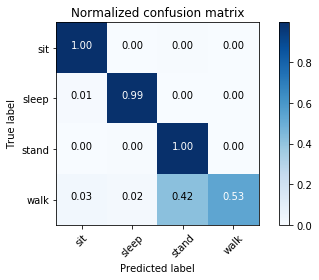

              precision    recall  f1-score   support

         sit       0.95      1.00      0.97       432
       sleep       0.97      0.99      0.98       445
       stand       0.72      1.00      0.84       688
        walk       1.00      0.53      0.70       623

   micro avg       0.86      0.86      0.86      2188
   macro avg       0.91      0.88      0.87      2188
weighted avg       0.90      0.86      0.85      2188



In [30]:
acc = accuracy_score(y_te, y_pred_2)
print(acc)

show_conf_matrix(y_te, y_pred_2, LABELS)
show_clf_report(y_te, y_pred_2, LABELS)

# Walk Algorithm

In [31]:
%run classifier_alg.ipynb

In [32]:
X_dict = {
    'id': subj_all_p,
    'x': [X_i[0] for X_i in X_all_p],
    'y': [X_i[1] for X_i in X_all_p],
    'z': [X_i[2] for X_i in X_all_p],
    'x_pca': [X_i_pca[0] for X_i_pca in X_pca_p],
    'y_pca': [X_i_pca[1] for X_i_pca in X_pca_p],
    'z_pca': [X_i_pca[2] for X_i_pca in X_pca_p],
    'label': y_all_p
}

df_rpy = pd.DataFrame(X_dict)

In [33]:
cols = ['x_pca', 'y_pca', 'z_pca']

df_pca = df_rpy[cols]     # patients

In [34]:
xyz_pca = np.array(df_pca.to_dict(orient='split')['data'])
dummy_y = np.array([-1 for i in range(len(xyz_pca))])

In [35]:
xyz_pca, y_temp = make_overlapping(xyz_pca, dummy_y)

In [36]:
xyz_pca.shape, df_pca.shape

((10939, 60, 3), (10998, 3))

In [37]:
walk_pred = classify_walk_2(xyz_pca)
walk_pred = np.array(walk_pred)

In [38]:
walk_pred

array([0, 0, 0, ..., 3, 3, 3])

In [39]:
walk_pred = np.array(walk_pred)

walk_pred.shape

(10939,)

In [40]:
walk_actual = np.array([3 if (df_rpy.loc[i, 'label']==3) else 0 for i in range(len(df_rpy))])

walk_actual.shape

(10998,)

In [41]:
print(walk_actual)

[0 0 0 ... 3 3 3]


## Walk Algorithm Evaluation

In [42]:
walk_lbl = ['NaN','walk']

0.8999908583965628


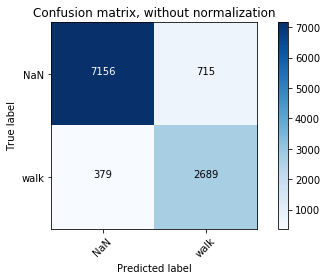

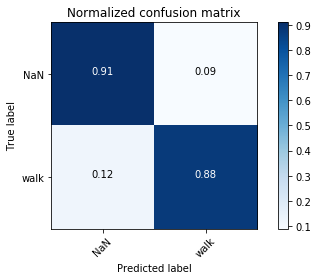

              precision    recall  f1-score   support

         NaN       0.95      0.91      0.93      7871
        walk       0.79      0.88      0.83      3068

   micro avg       0.90      0.90      0.90     10939
   macro avg       0.87      0.89      0.88     10939
weighted avg       0.90      0.90      0.90     10939



In [43]:
acc = accuracy_score(walk_actual[:walk_pred.shape[0]], walk_pred)
print(acc)

show_conf_matrix(walk_actual[:walk_pred.shape[0]], walk_pred, walk_lbl)
show_clf_report(walk_actual[:walk_pred.shape[0]], walk_pred, walk_lbl)

# Combine SVM and Walk Algorithm

In [44]:
X_test_new = get_inverse_X(X_test)

X_test_new

array([[[ 0.96,  0.02,  0.13],
        [ 0.87,  0.02,  0.19],
        [ 0.84, -0.05,  0.19],
        ...,
        [ 1.11,  0.13,  0.23],
        [ 0.91, -0.06,  0.21],
        [ 0.88, -0.05,  0.24]],

       [[-0.55, -0.61,  0.45],
        [-0.54, -0.61,  0.45],
        [-0.55, -0.61,  0.45],
        ...,
        [-0.54, -0.61,  0.45],
        [-0.54, -0.61,  0.45],
        [-0.54, -0.61,  0.45]],

       [[-0.92, -0.13,  0.  ],
        [-0.81, -0.14,  0.02],
        [-1.17, -0.28, -0.  ],
        ...,
        [-1.07, -0.28, -0.07],
        [-0.73, -0.09, -0.05],
        [-0.83, -0.13, -0.03]],

       ...,

       [[-0.19,  0.85, -0.41],
        [-0.19,  0.85, -0.41],
        [-0.19,  0.85, -0.41],
        ...,
        [-0.2 ,  0.85, -0.41],
        [-0.2 ,  0.85, -0.41],
        [-0.2 ,  0.85, -0.41]],

       [[-1.04, -0.22, -0.08],
        [-0.9 , -0.15, -0.05],
        [-0.92, -0.2 , -0.04],
        ...,
        [-1.01, -0.18,  0.01],
        [-0.96, -0.22, -0.01],
        [-0.92,

In [45]:
walk_pred = classify_walk_2(X_test_new)

In [46]:
y_pred_new = combine_2(X_test_new, y_pred)

0.9379238393322901


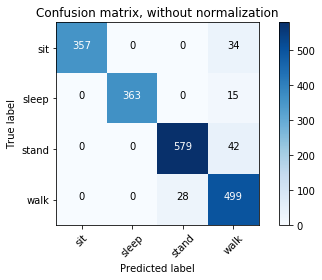

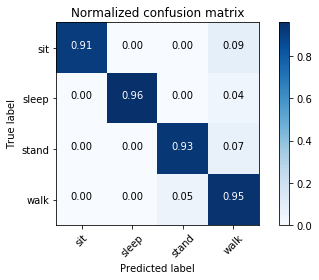

              precision    recall  f1-score   support

         sit       1.00      0.91      0.95       391
       sleep       1.00      0.96      0.98       378
       stand       0.95      0.93      0.94       621
        walk       0.85      0.95      0.89       527

   micro avg       0.94      0.94      0.94      1917
   macro avg       0.95      0.94      0.94      1917
weighted avg       0.94      0.94      0.94      1917



In [47]:
acc = accuracy_score(y_test, y_pred_new)
print(acc)

show_conf_matrix(y_test, y_pred_new, LABELS)
show_clf_report(y_test, y_pred_new, LABELS)

# Test Model with Some Subjects

In [1]:
%run test_model.ipynb

In [5]:
filename = basepath + 'model/knn_model_patients.pkl'

model = pickle.load(open(filename,'rb'))

Loading 3001's data
Finished prediction


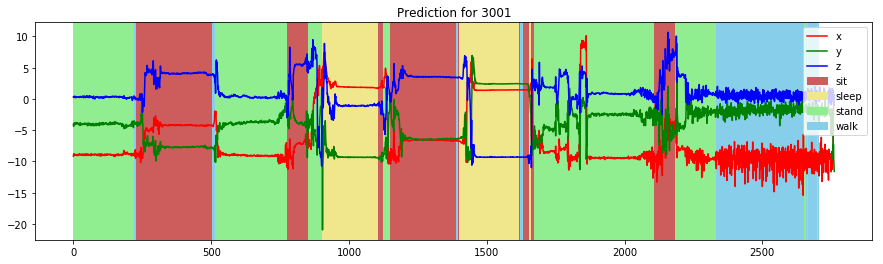

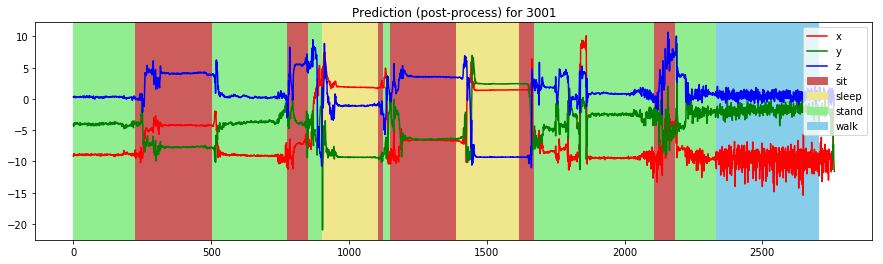

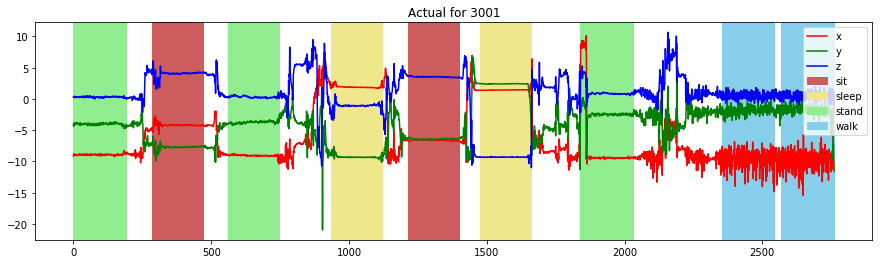

0.9505494505494505


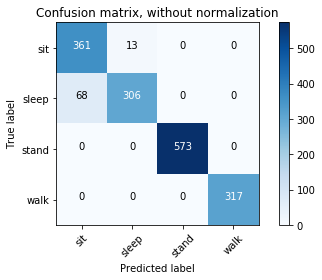

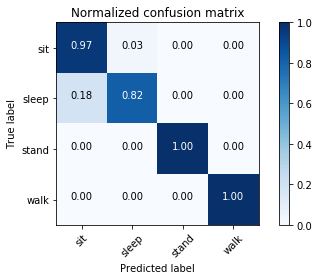

              precision    recall  f1-score   support

         sit       0.84      0.97      0.90       374
       sleep       0.96      0.82      0.88       374
       stand       1.00      1.00      1.00       573
        walk       1.00      1.00      1.00       317

   micro avg       0.95      0.95      0.95      1638
   macro avg       0.95      0.95      0.95      1638
weighted avg       0.95      0.95      0.95      1638

Loading 3002's data
Finished prediction


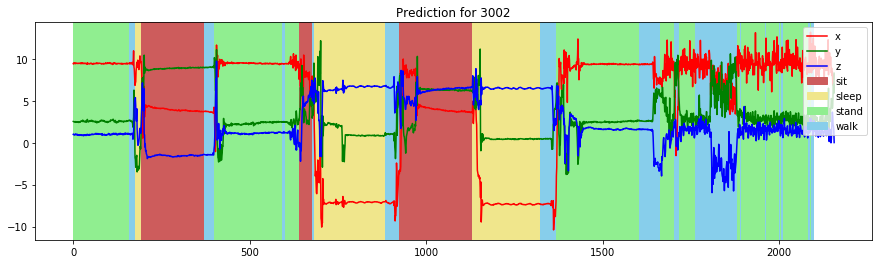

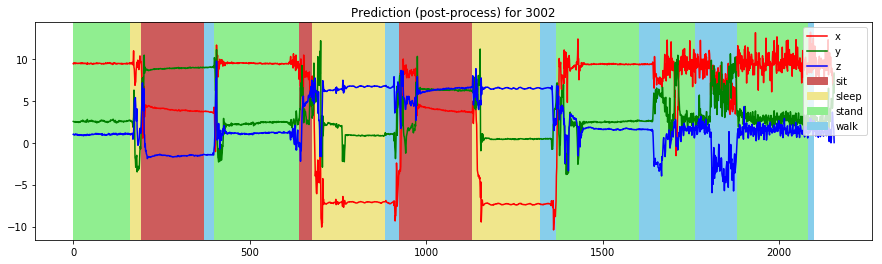

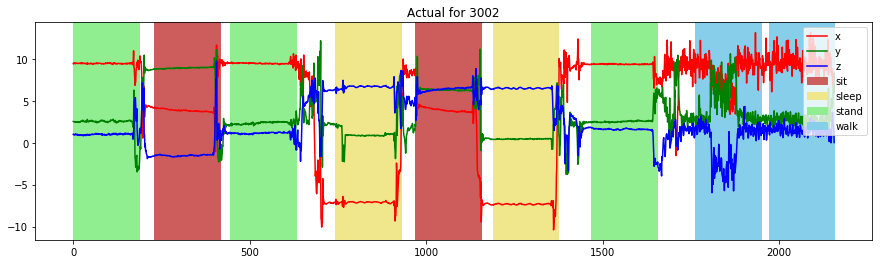

0.7290242386575513


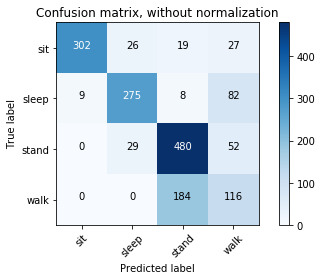

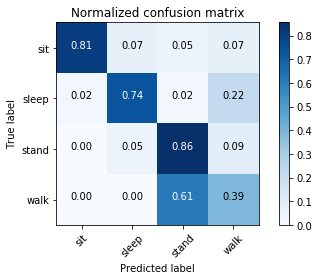

              precision    recall  f1-score   support

         sit       0.97      0.81      0.88       374
       sleep       0.83      0.74      0.78       374
       stand       0.69      0.86      0.77       561
        walk       0.42      0.39      0.40       300

   micro avg       0.73      0.73      0.73      1609
   macro avg       0.73      0.70      0.71      1609
weighted avg       0.74      0.73      0.73      1609

Loading 3003's data
Finished prediction


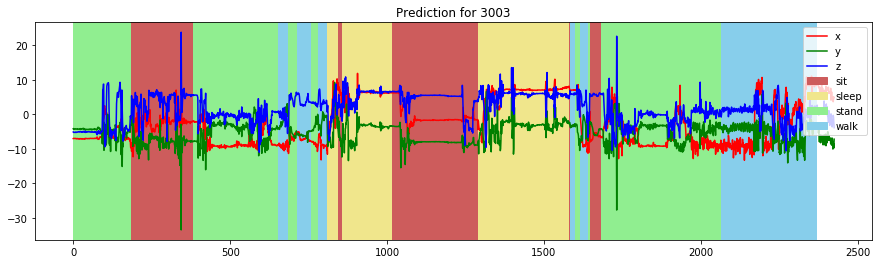

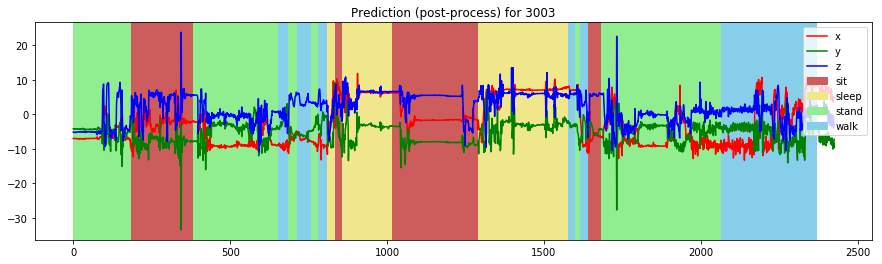

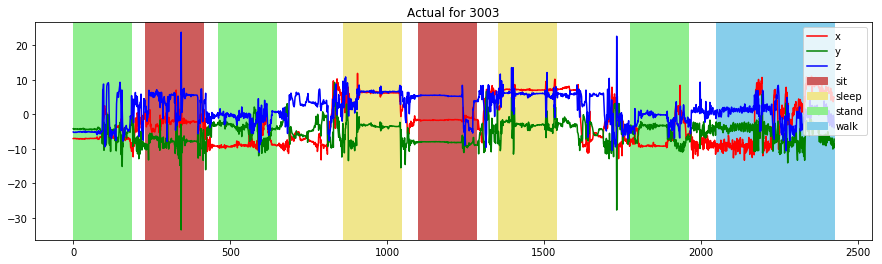

0.9476600985221675


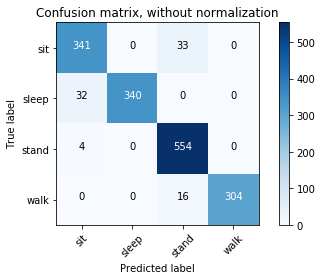

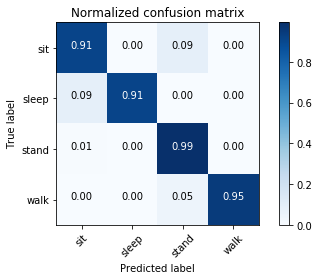

              precision    recall  f1-score   support

         sit       0.90      0.91      0.91       374
       sleep       1.00      0.91      0.96       372
       stand       0.92      0.99      0.95       558
        walk       1.00      0.95      0.97       320

   micro avg       0.95      0.95      0.95      1624
   macro avg       0.96      0.94      0.95      1624
weighted avg       0.95      0.95      0.95      1624

Loading 3004's data
Finished prediction


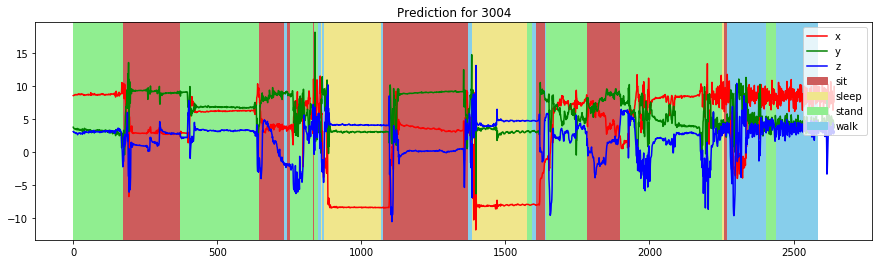

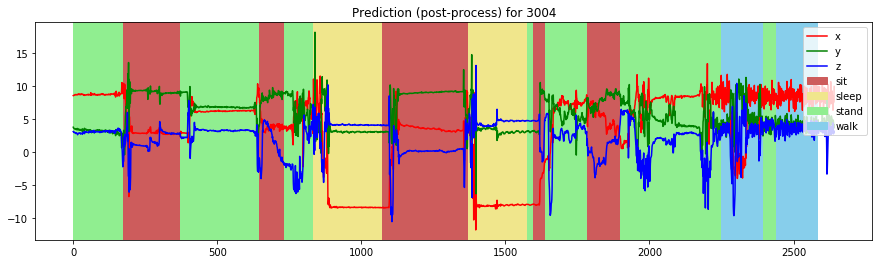

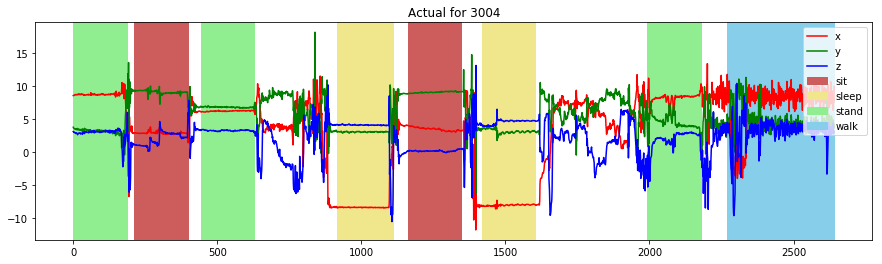

0.9005524861878453


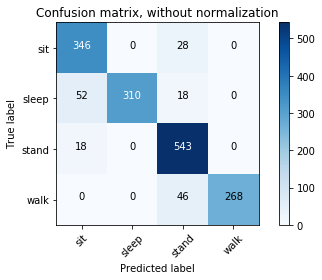

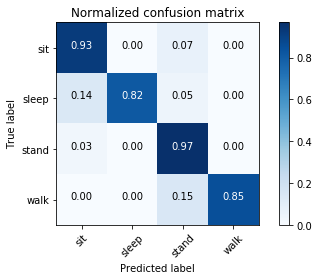

              precision    recall  f1-score   support

         sit       0.83      0.93      0.88       374
       sleep       1.00      0.82      0.90       380
       stand       0.86      0.97      0.91       561
        walk       1.00      0.85      0.92       314

   micro avg       0.90      0.90      0.90      1629
   macro avg       0.92      0.89      0.90      1629
weighted avg       0.91      0.90      0.90      1629

Loading 3005's data
Finished prediction


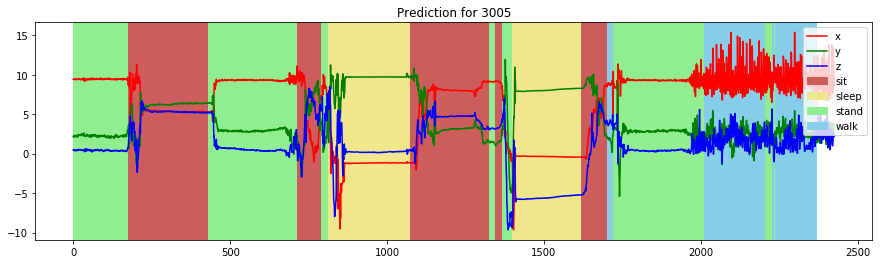

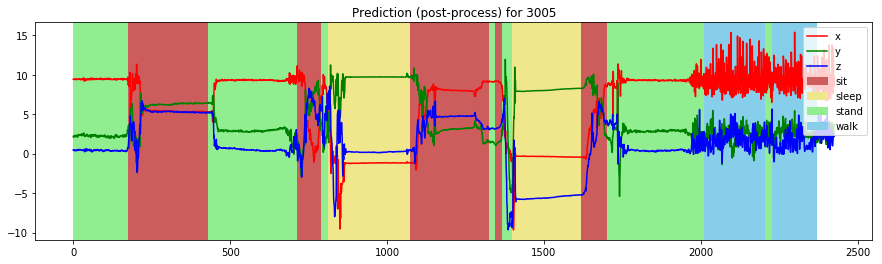

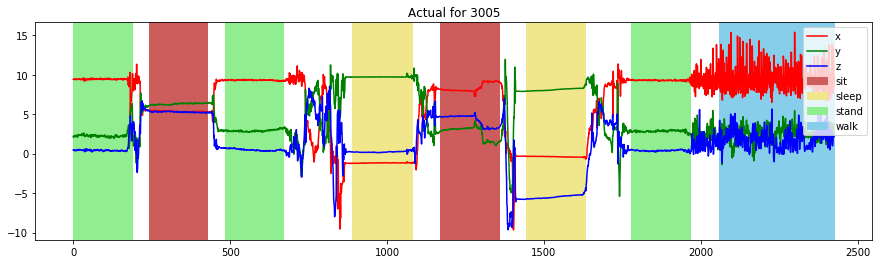

0.9513247073321011


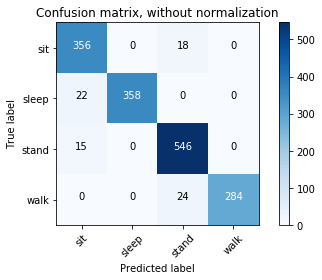

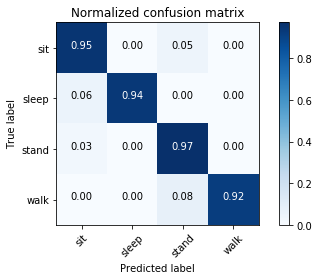

              precision    recall  f1-score   support

         sit       0.91      0.95      0.93       374
       sleep       1.00      0.94      0.97       380
       stand       0.93      0.97      0.95       561
        walk       1.00      0.92      0.96       308

   micro avg       0.95      0.95      0.95      1623
   macro avg       0.96      0.95      0.95      1623
weighted avg       0.95      0.95      0.95      1623



In [52]:
all_subjects = [str(i) for i in range(3001,3006)]

df_y_all = call_functions(all_subjects, pca_p)

In [ ]:
cols = ['x','y','z']
df_y_all

In [ ]:
LABELS = ['sit', 'sleep', 'stand', 'walk']

df_y_notnull = df_y_all[df_y_all['y_pred']!=-1]
df_y_notnull = df_y_notnull.dropna()
df_y_notnull = df_y_notnull.reset_index(drop=True)

print(df_y_notnull.shape)

actual_y = list(df_y_notnull['y_actual'])
pred_y = list(df_y_notnull['y_pred'])

last = len(pred_y)

for i in range(len(pred_y)):
    if(pred_y[i]==-1):
        last = i
        break

pred_y = pred_y[:last]
actual_y = actual_y[:last]

acc = accuracy_score(actual_y, pred_y)
print(acc)

show_conf_matrix(actual_y, pred_y, LABELS)
show_clf_report(actual_y, pred_y, LABELS)

labels_list = [0,1,2,3]
report = classification_report(actual_y, pred_y, labels_list, output_dict=True)
print(report['macro avg'])

# Segmentation Using Ruptures

In [4]:
person_id = '3001'

In [31]:
LABELS = label_list
LABELS

['sit', 'sleep', 'stand', 'walk']

Loading 3001's data
Finished prediction


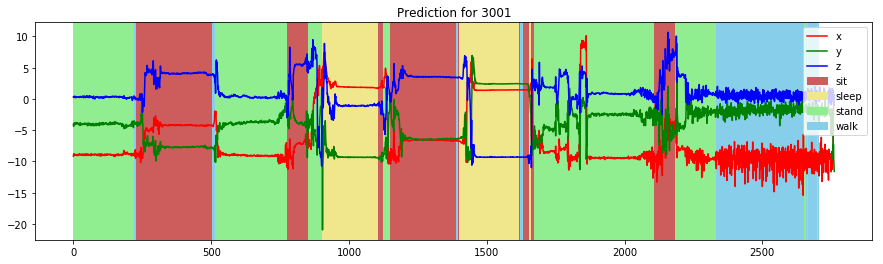

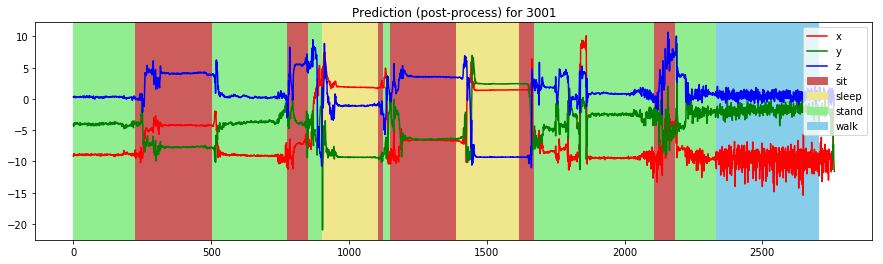

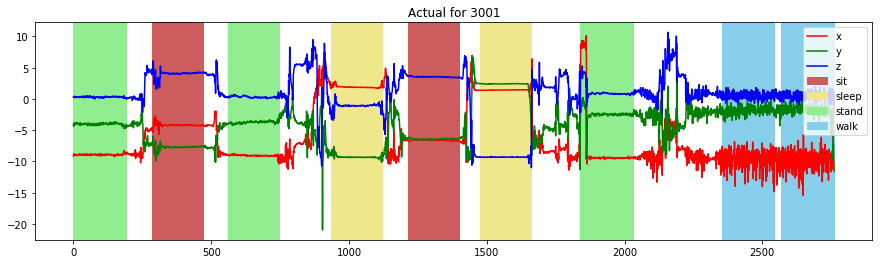

0.9505494505494505


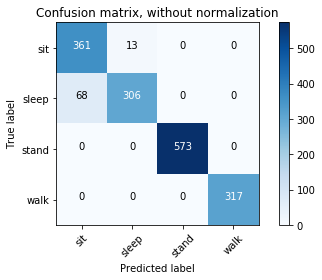

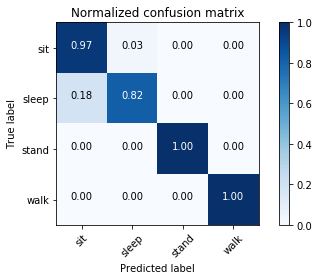

              precision    recall  f1-score   support

         sit       0.84      0.97      0.90       374
       sleep       0.96      0.82      0.88       374
       stand       1.00      1.00      1.00       573
        walk       1.00      1.00      1.00       317

   micro avg       0.95      0.95      0.95      1638
   macro avg       0.95      0.95      0.95      1638
weighted avg       0.95      0.95      0.95      1638



In [32]:
s = person_id
print("Loading {0}'s data".format(s))

df_sid = load_actual_timer(s)
df_test = load_data(s, df_sid)

X_vis_imp, ts_list_imp = preprocess_data(df_test, pca_p)
df_y = predict_combine(X_vis_imp, ts_list_imp)

df_test, df_y = prepare_actual_lb(df_test, df_y, df_sid)

actual_periods = get_actual_periods(df_test)
pred_periods = get_predicted_periods(df_y)
pp_all_run = postprocess_predicted(pred_periods, df_y)

df_y['y_pred'] = pd.Series(pp_all_run)
pp_periods = get_predicted_periods(df_y)
plot_highlighted(s, df_test, pred_periods, pp_periods, actual_periods)

evaluate(df_y)

In [33]:
cols = ['x','y','z']

df_xyz = df_test[cols]

X_one_person = df_xyz.to_dict(orient='split')['data']
X_one_person = np.array(X_one_person)

In [34]:
# change point detection
model_alg = "l1"
algo = rpt.Pelt(model=model_alg, min_size=3, jump=5).fit(X_one_person)

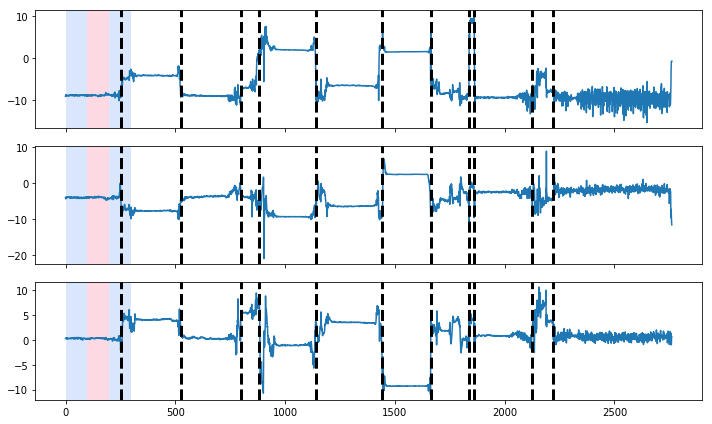

In [46]:
bkps = [100,200,300]
my_bkps = algo.predict(pen=250)

# show results
fig, ax = rpt.display(X_one_person, bkps, my_bkps, figsize=(10, 6))
plt.show()

In [48]:
my_bkps

[255, 525, 800, 880, 1140, 1440, 1665, 1840, 1860, 2125, 2220, 2762]

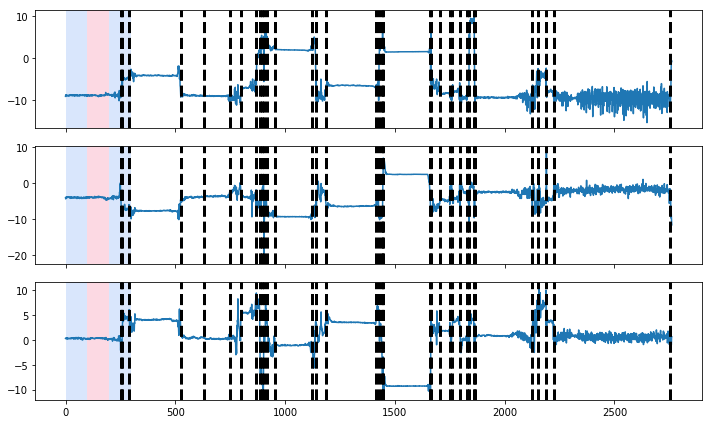

In [43]:
bkps = [100,200,300]
my_bkps = algo.predict(pen=20)

# show results
fig, ax = rpt.display(X_one_person, bkps, my_bkps, figsize=(10, 6))
plt.show()

In [49]:
person_id = '3002'
s = person_id
print("Loading {0}'s data".format(s))

df_sid = load_actual_timer(s)
df_test = load_data(s, df_sid)

cols = ['x','y','z']

df_xyz = df_test[cols]

X_one_person = df_xyz.to_dict(orient='split')['data']
X_one_person = np.array(X_one_person)

model_alg = "l1"
algo = rpt.Pelt(model=model_alg, min_size=3, jump=5).fit(X_one_person)

bkps = [100,200,300]
my_bkps = algo.predict(pen=250)

# show results
fig, ax = rpt.display(X_one_person, bkps, my_bkps, figsize=(10, 6))
plt.show()

Loading 3002's data


In [50]:
cols = ['x','y','z']

df_xyz = df_test[cols]

X_one_person = df_xyz.to_dict(orient='split')['data']
X_one_person = np.array(X_one_person)

model_alg = "l1"
algo = rpt.Pelt(model=model_alg, min_size=3, jump=5).fit(X_one_person)

bkps = [100,200,300]
my_bkps = algo.predict(pen=250)

# show results
fig, ax = rpt.display(X_one_person, bkps, my_bkps, figsize=(10, 6))
plt.show()

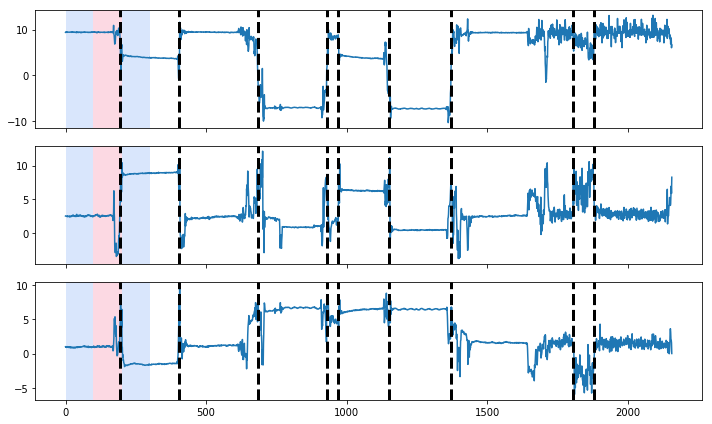

In [51]:
model_alg = "l1"
algo = rpt.Pelt(model=model_alg, min_size=3, jump=5).fit(X_one_person)

bkps = [100,200,300]
my_bkps = algo.predict(pen=250)

# show results
fig, ax = rpt.display(X_one_person, bkps, my_bkps, figsize=(10, 6))
plt.show()